In [91]:
import numpy as np
from scipy.stats import truncnorm
import matplotlib.pyplot as plt

In [10]:
def grid_maker(K):
    '''
    input: K, intended grid number
    output: wage_grid_points, list of K+1 number of grid points btw 0 & 1
    '''
    grid_length = 1/K
    wage_grid_points = [i*grid_length for i in range(K+1)]
    
    return wage_grid_points

In [62]:
def pdf_maker(wage_grid_points):
    '''
    input: wage_grid_points, domain
    output: pseudo_pdf, intended pdf for each grid point
    
    cf) truncnorm.cdf(point, a, b) spits out cumulative probability at point w/ truncated norm on [a,b]
    '''
    pseudo_pdf = []
    myclip_a = 0
    myclip_b = 1
    my_mean = 0.5
    my_std = 0.1
    a, b = (myclip_a - my_mean) / my_std, (myclip_b - my_mean) / my_std

    for i in range(len(wage_grid_points)):
        if i == 0:
            half_point = wage_grid_points[i+1]/2
            pseudo_pdf.append(truncnorm.cdf(half_point,a,b,loc=my_mean,scale=my_std))
        elif i == len(wage_grid_points)-1:
            half_point = (wage_grid_points[i]+wage_grid_points[i-1])/2
            pseudo_pdf.append(1-truncnorm.cdf(half_point,a,b,loc=my_mean,scale=my_std))
        else:
            half_point_1 = (wage_grid_points[i]+wage_grid_points[i+1])/2
            half_point_2 = (wage_grid_points[i]+wage_grid_points[i-1])/2
            pseudo_pdf.append(truncnorm.cdf(half_point_1,a,b,loc=my_mean,scale=my_std)-truncnorm.cdf(half_point_2,a,b,loc=my_mean,scale=my_std))
    
    return pseudo_pdf    

In [120]:
def value_matrix(wage_grid_points, T, beta, C):
    '''
    input: wage_grid_points; domain, T; time, beta; discount factor, C; compensation
    output: matrix of expected value at each wage level for time 0 to T
    '''
    value_matrix = [0 for i in range(T)]
    res_wage_list = [0 for i in range(T)]
    pseudo_pdf = pdf_maker(wage_grid_points)
        
    #(1) Last Period(t=T) Calculate
    value_temp = [max(i, C) for i in wage_grid_points]
    value_matrix.append(value_temp)
    res_wage_list.append(C)
    
    #(2) Backward Induction for value_matrix
    for i in range(T):
        t = (T-1)-i
        value_temp = []
        for j in range(len(wage_grid_points)):
            accept = ((1-beta**(T-t+1))*wage_grid_points[j])/(1-beta)
            reject = C + beta*np.inner(value_matrix[t+1], pseudo_pdf)
            value_temp.append(max(accept, reject))
        value_matrix[t] = value_temp

    #(3) Backward Induction for res_wage_list
    for i in range(T):
        t = (T-1)-i
        reject = C + beta*np.inner(value_matrix[t+1], pseudo_pdf)
        res_wage_list[t] = (1-beta)*reject/(1-beta**(T-t+1))


    return value_matrix, res_wage_list

# Question 2.9
used the above function "value_matrix"

### (1) For the size of the grid K, experiment until you get satisfactory results

In [126]:
grid_30 = grid_maker(30)
grid_50 = grid_maker(50)
grid_100 = grid_maker(100)

T = 50
beta = 0.97
C = 0.3

In [132]:
matrix_30, res_30 = value_matrix(grid_30, T, beta, C)
matrix_50, res_50 = value_matrix(grid_50, T, beta, C)
matrix_100, res_100 = value_matrix(grid_100, T, beta, C)

<function matplotlib.pyplot.show(close=None, block=None)>

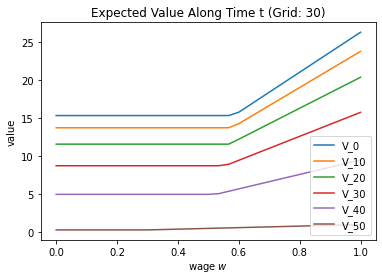

In [148]:
fig, ax = plt.subplots()                          # define plot
for i in [0,10,20,30,40,50]:                      # plot iterates
    ax.plot(grid_30,matrix_30[i], label=f'V_{i}')

ax.set_title('Expected Value Along Time t (Grid: 30)')
ax.set(xlabel='wage $w$',ylabel='value')          # describe axes
ax.legend(loc='lower right')                      # display legend    

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

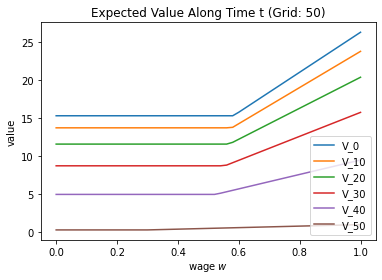

In [149]:
fig, ax = plt.subplots()                          # define plot
for i in [0,10,20,30,40,50]:                      # plot iterates
    ax.plot(grid_50,matrix_50[i], label=f'V_{i}')

ax.set_title('Expected Value Along Time t (Grid: 50)')
ax.set(xlabel='wage $w$',ylabel='value')          # describe axes
ax.legend(loc='lower right')                      # display legend    

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

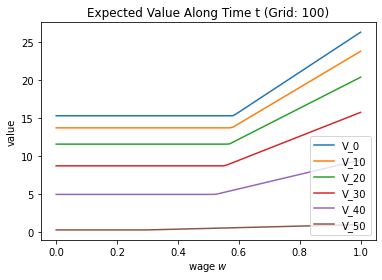

In [150]:
fig, ax = plt.subplots()                          # define plot
for i in [0,10,20,30,40,50]:                      # plot iterates
    ax.plot(grid_100,matrix_100[i], label=f'V_{i}')

ax.set_title('Expected Value Along Time t (Grid: 100)')
ax.set(xlabel='wage $w$',ylabel='value')          # describe axes
ax.legend(loc='lower right')                      # display legend    

plt.show

### (2) Plot the Reservation Wage as a Function of t (Under Grid Num = 100)

<function matplotlib.pyplot.show(close=None, block=None)>

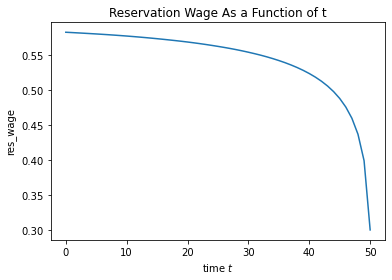

In [199]:
t = list(range(51))
fig, ax = plt.subplots()                          # define plot
ax.plot(t, res_100)
ax.set_title('Reservation Wage As a Function of t')
ax.set(xlabel='time $t$', ylabel='res_wage')          # describe axes

plt.show

# Question 2.10
used functions defined below   with. grid num = 1000

\begin{equation}
        (\frac{1-\beta^{T-t+1}}{1-\beta})\bar{w}_{t} = C + \beta\frac{1-\beta^{T-t}}{1-\beta}
        (EW^{\prime} + \frac{1}{K}\Sigma^{\bar{w}_{t+1}}_{i=0}F(w^i)) 
\end{equation}



Now we need to use the above relation.
While doing so, we should approximate the $ \bar{w}_{t+1} $ with discretized value



To approximate properly, I increased the grid num to 1000 from 100

In [179]:
grid_1000 = grid_maker(1000)

In [194]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def sigma_part(res_wage_tmr):
    '''
    input: res_wage_tmr, tmr's res_wage
    output: sigma_part, sigma/K 
    '''
    nearest_discretized_value = find_nearest(grid_1000, res_wage_tmr)
    grid_sigma = grid_1000[:grid_1000.index(nearest_discretized_value)+1]
    
    sigma_sum = 0
    myclip_a = 0
    myclip_b = 1
    my_mean = 0.5
    my_std = 0.1
    a, b = (myclip_a - my_mean) / my_std, (myclip_b - my_mean) / my_std
    for i in grid_sigma: 
        if i == grid_sigma[-1]:
            half_point = (i + grid_sigma[-2])/2
            sigma_sum = sigma_sum + truncnorm.cdf(half_point,a,b,loc=my_mean,scale=my_std)
        else:    
            location = grid_sigma.index(i)
            half_point = (i + grid_sigma[location+1])/2
            sigma_sum = sigma_sum + truncnorm.cdf(half_point,a,b,loc=my_mean,scale=my_std)

    return sigma_sum/1000

In [185]:
EW_prime = np.inner(grid_1000, pdf_maker(grid_1000))
T = 50
beta = 0.97
C = 0.3

In [196]:
res_wage_list = [0 for i in range(50)]
res_wage_list.append(C)

for i in range(T):
    t = (T-1)-i
    sigma_sum = sigma_part(res_wage_list[t+1])
    RHS = C + beta*(1-beta**(T-t))*(EW_prime+sigma_sum)/(1-beta)
    LHS_coef = (1-beta**(T-t+1))/(1-beta)
    res_wage_list[t] = RHS/LHS_coef

<function matplotlib.pyplot.show(close=None, block=None)>

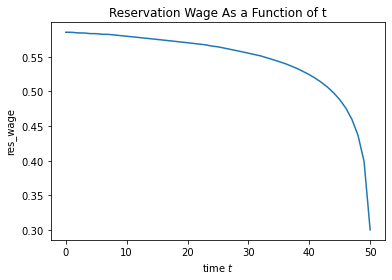

In [198]:
t = list(range(51))
fig, ax = plt.subplots()                          # define plot
ax.plot(t, res_wage_list)
ax.set_title('Reservation Wage As a Function of t')
ax.set(xlabel='time $t$', ylabel='res_wage')          # describe axes

plt.show

### plot the result from 2.9 and 2.10 together

<function matplotlib.pyplot.show(close=None, block=None)>

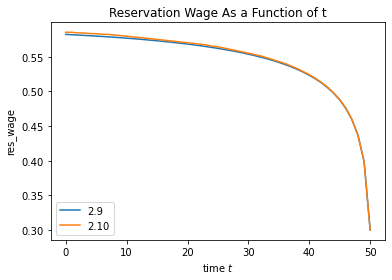

In [200]:
t = list(range(51))
fig, ax = plt.subplots()                          # define plot
ax.plot(t, res_100, label='2.9')
ax.plot(t, res_wage_list, label='2.10')

ax.set_title('Reservation Wage As a Function of t')
ax.set(xlabel='time $t$',ylabel='res_wage')          # describe axes
ax.legend(loc='lower left')                      # display legend    

plt.show

results from 2.9 and 2.10 showed <b>same</b> results <br>
Since I increased the grid num to 1000 to approximate properly, they showed slight difference on initial period

# Question 2.11
I just rewrote the function that I used for 2.9 with different variance

In [202]:
def pdf_maker2(wage_grid_points):
    '''
    input: wage_grid_points, domain
    output: pseudo_pdf, intended pdf for each grid point
    
    cf) truncnorm.cdf(point, a, b) spits out cumulative probability at point w/ truncated norm on [a,b]
    '''
    pseudo_pdf = []
    myclip_a = 0
    myclip_b = 1
    my_mean = 0.5
    my_std = 1
    a, b = (myclip_a - my_mean) / my_std, (myclip_b - my_mean) / my_std

    for i in range(len(wage_grid_points)):
        if i == 0:
            half_point = wage_grid_points[i+1]/2
            pseudo_pdf.append(truncnorm.cdf(half_point,a,b,loc=my_mean,scale=my_std))
        elif i == len(wage_grid_points)-1:
            half_point = (wage_grid_points[i]+wage_grid_points[i-1])/2
            pseudo_pdf.append(1-truncnorm.cdf(half_point,a,b,loc=my_mean,scale=my_std))
        else:
            half_point_1 = (wage_grid_points[i]+wage_grid_points[i+1])/2
            half_point_2 = (wage_grid_points[i]+wage_grid_points[i-1])/2
            pseudo_pdf.append(truncnorm.cdf(half_point_1,a,b,loc=my_mean,scale=my_std)-truncnorm.cdf(half_point_2,a,b,loc=my_mean,scale=my_std))
    
    return pseudo_pdf    

In [203]:
def value_matrix2(wage_grid_points, T, beta, C):
    '''
    input: wage_grid_points; domain, T; time, beta; discount factor, C; compensation
    output: matrix of expected value at each wage level for time 0 to T
    '''
    value_matrix = [0 for i in range(T)]
    res_wage_list = [0 for i in range(T)]
    pseudo_pdf = pdf_maker2(wage_grid_points)
        
    #(1) Last Period(t=T) Calculate
    value_temp = [max(i, C) for i in wage_grid_points]
    value_matrix.append(value_temp)
    res_wage_list.append(C)
    
    #(2) Backward Induction for value_matrix
    for i in range(T):
        t = (T-1)-i
        value_temp = []
        for j in range(len(wage_grid_points)):
            accept = ((1-beta**(T-t+1))*wage_grid_points[j])/(1-beta)
            reject = C + beta*np.inner(value_matrix[t+1], pseudo_pdf)
            value_temp.append(max(accept, reject))
        value_matrix[t] = value_temp

    #(3) Backward Induction for res_wage_list
    for i in range(T):
        t = (T-1)-i
        reject = C + beta*np.inner(value_matrix[t+1], pseudo_pdf)
        res_wage_list[t] = (1-beta)*reject/(1-beta**(T-t+1))


    return value_matrix, res_wage_list

In [204]:
matrix_100_MPS, res_100_MPS = value_matrix2(grid_100, T, beta, C)

## (1) Comparison of Expected Value at Time t = 0, gridnum = 100

<function matplotlib.pyplot.show(close=None, block=None)>

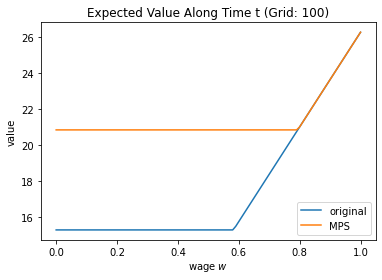

In [207]:
fig, ax = plt.subplots()                          # define plot
ax.plot(grid_100,matrix_100[0], label='original')
ax.plot(grid_100,matrix_100_MPS[0], label='MPS')

ax.set_title('Expected Value Along Time t (Grid: 100)')
ax.set(xlabel='wage $w$',ylabel='value')          # describe axes
ax.legend(loc='lower right')                      # display legend    

plt.show

## (2) Comparison of Res Wage Scheme, gridnum = 100

<function matplotlib.pyplot.show(close=None, block=None)>

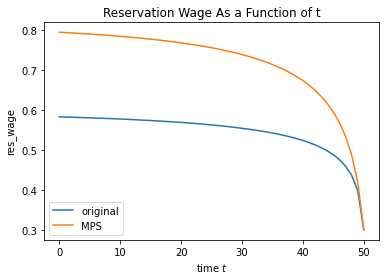

In [209]:
t = list(range(51))
fig, ax = plt.subplots()                          # define plot
ax.plot(t, res_100, label='original')
ax.plot(t, res_100_MPS, label='MPS')

ax.set_title('Reservation Wage As a Function of t')
ax.set(xlabel='time $t$',ylabel='res_wage')          # describe axes
ax.legend(loc='lower left')                      # display legend    

plt.show

According to the graph above, <br> 
1. under the Mean Preserving Spread (MPS) the worker has <b>higher expected value at time t=0</b> <br>
   This is because, worker has higher probability of getting higher wage, he has a better option to wait for the next offer. <br>
   
2. This pattern is well described with the <b>Reservation Wage scheme</b> over time t <br>
Since the worker has higher probability of receiving higher wage offer tomorrw, he could set his reservation wage higher. <br>
Whereas, under the both CDF the worker sets his reservation wage at a compensation level at time t=T(:=50).
 